# INRIA Holidays database - CNN

## Autores: Benjamín Irarrázabal / Joaquín Zepeda

Este notebook reúne los códigos necesarios para calcular las medidas de similitud, el ranking y el ploteo de las imágenes similares a la consultada. \\
Este considera las Features ya extraídas por las funciones definidas en otro Notebook (también entregado), importadas desde GitHub para trabajar. \\
Cabe destacar que este código de está corriendo en Google Colab. \\
**Ver Anexo de Informe para Instrucciones detalladas**

# Importamos librerías importantes

In [1]:
import cv2
import matplotlib.pyplot as plt
import pandas as pd
import glob
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
import numpy as np
from scipy.spatial import distance
import pickle

# Descargamos imágenes del database

In [2]:
!mkdir jpg1
%cd /content/jpg1
!wget ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz
!tar -xf jpg1.tar.gz

/content/jpg1
--2022-07-14 17:18:00--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg1.tar.gz
           => ‘jpg1.tar.gz’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE jpg1.tar.gz ... 1141827194
==> PASV ... done.    ==> RETR jpg1.tar.gz ... done.
Length: 1141827194 (1.1G) (unauthoritative)

jpg1.tar.gz         100%[===================>]   1.06G  11.0MB/s    in 2m 19s  

2022-07-14 17:20:21 (7.84 MB/s) - ‘jpg1.tar.gz’ saved [1141827194]



In [3]:
%cd ..
!mkdir jpg2
%cd /content/jpg2
!wget ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg2.tar.gz
!tar -xf jpg2.tar.gz
%cd ..

/content
/content/jpg2
--2022-07-14 17:20:34--  ftp://ftp.inrialpes.fr/pub/lear/douze/data/jpg2.tar.gz
           => ‘jpg2.tar.gz’
Resolving ftp.inrialpes.fr (ftp.inrialpes.fr)... 194.199.18.221
Connecting to ftp.inrialpes.fr (ftp.inrialpes.fr)|194.199.18.221|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/lear/douze/data ... done.
==> SIZE jpg2.tar.gz ... 1701364177
==> PASV ... done.    ==> RETR jpg2.tar.gz ... done.
Length: 1701364177 (1.6G) (unauthoritative)

jpg2.tar.gz         100%[===================>]   1.58G  5.49MB/s    in 3m 23s  

2022-07-14 17:23:59 (7.98 MB/s) - ‘jpg2.tar.gz’ saved [1701364177]

/content


# Clonamos repositorio Git para obtener las Features ya extraídas

In [4]:
!git clone https://github.com/BenjaminIrarrazabal/Laboratorios_Inteligencia.git
!ls
%cd Laboratorios_Inteligencia/Proyecto\ final/features

import pickle
# load saved model
with open('img_query_cnn_pkl' , 'rb') as f:
    img_query_cnn = pickle.load(f)
with open('img_database_cnn_pkl' , 'rb') as f:
    img_database_cnn = pickle.load(f)

Cloning into 'Laboratorios_Inteligencia'...
remote: Enumerating objects: 2329, done.
remote: Counting objects: 100% (131/131), done.
remote: Compressing objects: 100% (81/81), done.
remote: Total 2329 (delta 58), reused 112 (delta 45), pack-reused 2198
Receiving objects: 100% (2329/2329), 286.90 MiB | 20.81 MiB/s, done.
Resolving deltas: 100% (58/58), done.
Checking out files: 100% (2211/2211), done.
jpg1  jpg2  Laboratorios_Inteligencia  sample_data
/content/Laboratorios_Inteligencia/Proyecto final/features


## Renombramos la columna de Features para trabajar posteriormente

In [5]:
img_query_cnn = img_query_cnn.rename(columns={'Feature vector': 'Features'})
img_database_cnn = img_database_cnn.rename(columns={'Feature vector': 'Features'})

# Medida de Similitud, Distancia Euclidiana

In [6]:
# A continuación, se define una función que toma un vector (para la imagen de consulta, img_q) y un conjunto de vectores (para las imágenes de database, img_d)
# y aplica la distancia entre vectores, devolviendo un nuevo vector con estas medidas de similitud
def distance_vector(img_q, img_d):
  """
  Cálculo del vector de distancia entre las características de una imagen y las
  características de todas las imágenes del database.

  :param numpy.ndarray img_q: Características
  :param pandas.DataFrame img_d: database de imágenes

  :return arreglo de numpy con distancias respectivas
  """
  # Se define una lista vacía que guarda las distancias entre vectores.
  Distance_vector = []
  # Se recorre el dataframe de características de database y se calcula la distancia.
  for i in range(len(img_d['Features'])):
    Distance = distance.euclidean(img_q, img_d['Features'].iloc[i])
    Distance_vector.append(Distance)
  # Se retorna un arreglo de numpy con el vector de distancias correspondiente.
  return np.array(Distance_vector)

# Ranking Normalizado

In [24]:
# La siguiente función tiene como objetivo calcular el ranking normalizado y entregar otros valores de importancia,
# como por ejemplo, el nombre de las imágenes ordenado por relevancia, etc.
def rank_normalizado(img_q, Lista_Imagenes, img_d = img_database_cnn, query = img_query_cnn):
  """
  Cálculo de Ranking Normalizado y ordenamiento de imágenes según relevancia

  :param string img_q: Nombre de la imagen consultada
  :param string Lista_Imagenes: Define si se quiere o no la lista de imágenes por orden de relevancia
  :param pandas.DataFrame img_d: Database de features
  :param pandas.DataFrame query: Features de imágenes de consulta

  :return Ranking Normalizado, Lista de imágenes relevantes, Número de imagenes relevantes para calcular la cantidad de aciertos.
  """
  # Se definen variables y listas.
  Nrel = 0
  R = []
  d_names = img_d['Name']
  N = len(d_names)
  Suma = 0
  q_names = query['Name']
  Features = query['Features']
  # Iteración que busca las características de la imagen de consulta en la base de datos.
  for i in range(len(query['Name'])):
      if img_q == q_names.iloc[i]:
          feature_q = Features.iloc[i]
  # Se buscan los mínimos dentro del vector de distancias calculado.
  D_vector = distance_vector(feature_q, img_d)
  class_img_q = img_q[1:4]
  posiciones = []
  arr = D_vector.copy()
  arr = sorted(arr)
  minimos = arr[0:20]
  # Se guardan las posiciones de los mínimos encontrados.
  for numero in minimos:
    for i in range(len(D_vector)):
      if numero == D_vector[i] and ((i in posiciones) == False):
        posiciones.append(i)
  # Se busca la cantidad de imágenes relevantes en el database.
  for i in range(len(d_names)):
    class_img_d = (d_names.iloc[i])[1:4]
    if class_img_d == class_img_q:
      Nrel += 1
  # Cálculo de constante.
  Constant = Nrel*(Nrel+1)/2
  # Cálculo de sumatoria.
  for i in range(Nrel):
    Suma += (posiciones[i]-Constant)
  # Se realiza el retorno de la función dependiendo de lo escogido.
  if Lista_Imagenes == 'Si':
    Name_imagenes = []
    for posicion in posiciones:
      Name_imagenes.append(d_names.iloc[posicion])
    return (Suma/(Nrel*N)), Name_imagenes[0:10], Nrel

  elif Lista_Imagenes == 'No':
    return (Suma/(Nrel*N))
  else:
    print('Por favor revise los parámetros ingresados')

In [16]:
# La siguiente función busca aplicar el rank normalizado a todas las imágenes de un respectivo frame entregado.
def rank_normalized_frame(img_q):
  """
  Devolver frame con todos los rankings y su imagen de consulta asociada.

  :param pandas.DataFrame img_q: Features de imágenes de consulta

  :return DataFrame con los nombres de las imágenes de consulta y su respectivo ranking
  """
  names = img_q['Name']
  ranking_N_frame = pd.DataFrame(columns=['Name', 'Rank'])
  # Se aplica rank_normalizado recorriendo todas las imágenes de consulta y se guardan en un DataFrame.
  for i in range(len(names)):
    Rank = rank_normalizado(names.iloc[i], Lista_Imagenes='No')
    ranking_N_frame = ranking_N_frame.append({'Name': names.iloc[i], 'Rank': Rank}, ignore_index=True)
  return ranking_N_frame

In [17]:
rank_frame_CNN = rank_normalized_frame(img_query_cnn)

In [18]:
rank_frame_CNN

,Name,Rank
0,103500,0.252943
1,126100,0.295156
2,118800,0.106963
3,128800,0.339051
4,127600,0.526236
...,...,...
495,149800,0.277497
496,139300,0.440296
497,146800,0.112008
498,148200,0.427178


In [19]:
# create an iterator object with write permission
with open('Rank_CNN_pkl', 'wb') as file:
    pickle.dump(rank_frame_CNN, file)

In [21]:
"""
Luego de clonar el Git para descargar las features, se modifica el directorio actual, por lo que se 
actualiza para imprimir las imágenes de forma más eficiente.
"""
import os
 # Change the current working directory
os.chdir('/content')

In [25]:
def plot_rank(img_q):
    """
    Plotear imagen de consulta y las asociadas al ranking

    :param string img_q: Nombre de una imagen de consulta

    :return plot_images, print(cantidad de aciertos)
    """
    # Aplicamos Rank_Normalizado a la imagen de consulta, encontrando las imágenes más similares en el database.
    Rank, L, Nrel = rank_normalizado(img_q, Lista_Imagenes = 'Si')
    # Buscamos la imagen en una de las dos carpetas del database, jpg1 o jpg2 y se le aplica plot.
    try:
        img_bgr = cv2.imread('jpg1/jpg/' + img_q + '.jpg')
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Imagen Consultada: ' + img_q)
    except:
        img_bgr = cv2.imread('jpg2/jpg/' + img_q + '.jpg')
        img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
        plt.axis('off')
        plt.title('Imagen Consultada: ' + img_q) 
    # Se realiza un conjunto de 10 imágenes para mostrar el ranking
    fig = plt.figure(figsize=(15, 15))
    rows = 5
    columns = 2
    number = 1
    # Se define una cantidad de aciertos para registrar el desempeño de la búsqueda.
    Aciertos = 0
    # Se plotean las imágenes asociadas al ranking buscándolas en jpg1 o jpg2.
    for name in L:
        try:
            fig.add_subplot(rows, columns, number)
            img_bgr = cv2.imread('jpg1/jpg/' + name + '.jpg')
            img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.axis('off')
            plt.title('Ranking '+ str(number)+', '+ name)
            number += 1
            if img_q[1:4] == name[1:4]:
              Aciertos += 1
        except:
            fig.add_subplot(rows, columns, number)
            img_bgr = cv2.imread('jpg2/jpg/' + name + '.jpg')
            img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
            plt.imshow(img)
            plt.axis('off')
            plt.title('Ranking '+ str(number)+', '+ name)
            number += 1
            if img_q[1:4] == name[1:4]:
              Aciertos += 1
    # Se imprime la cantidad de aciertos del algoritmo, ie, 
    # cantidad de imágenes con la misma clase que la imagen consultada
    print('Cantidad de Aciertos: ' + str(Aciertos) +' de '+ str(Nrel))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Cantidad de Aciertos: 1 de 2


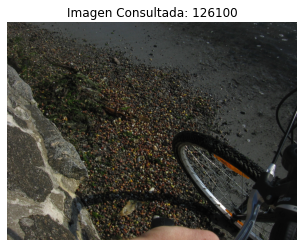

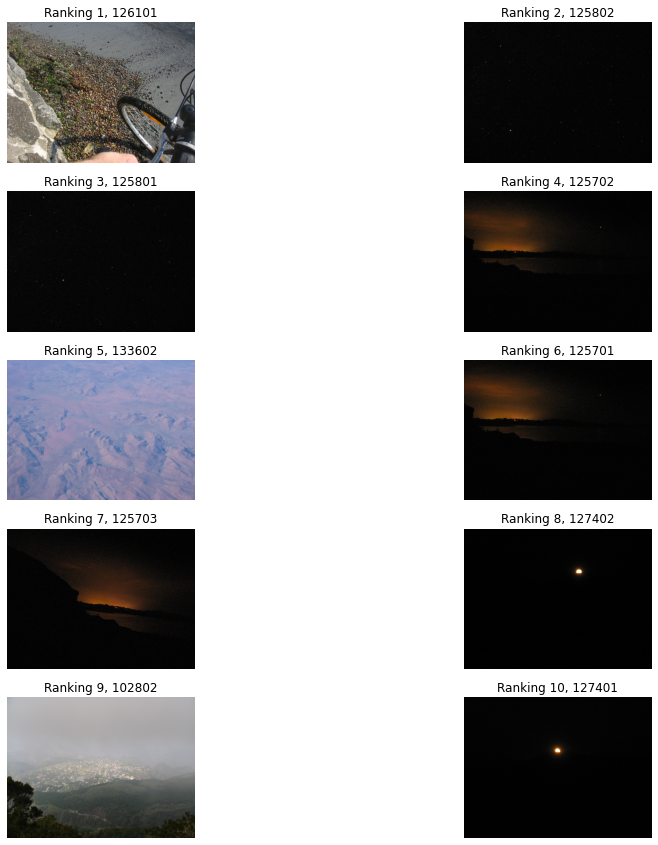

In [27]:
plot_rank('126100')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Cantidad de Aciertos: 0 de 2


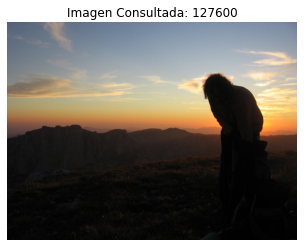

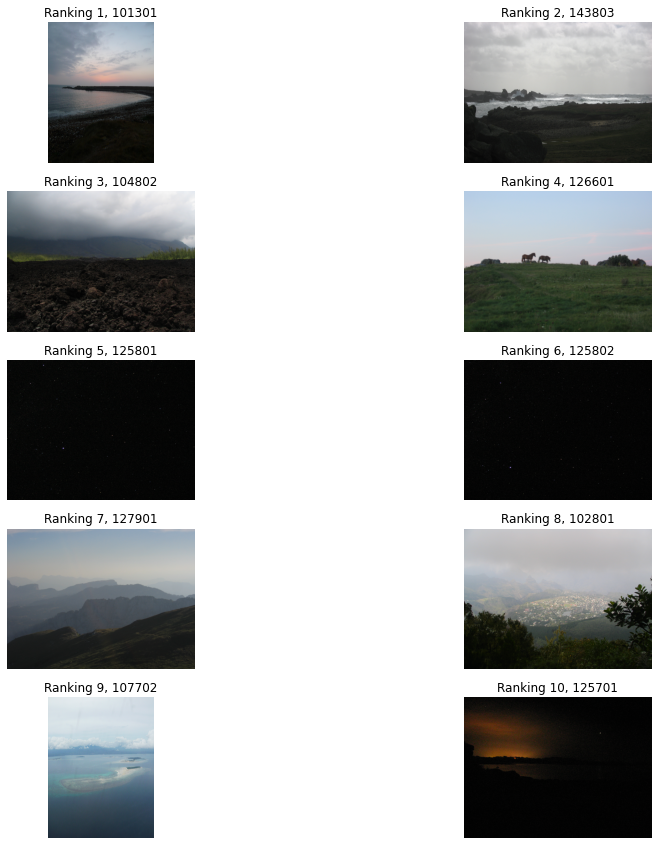

In [28]:
plot_rank('127600')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Cantidad de Aciertos: 1 de 1


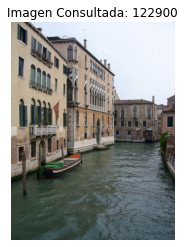

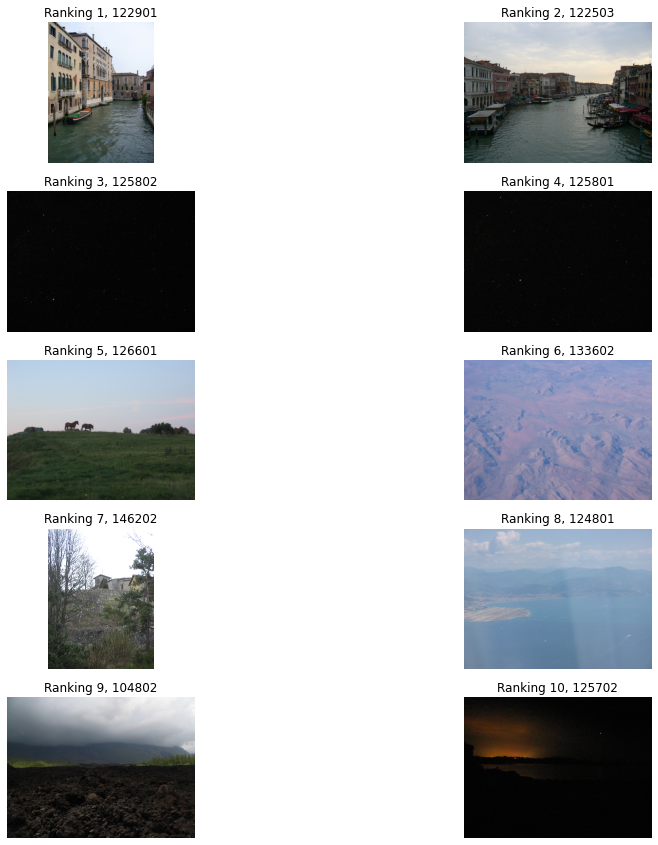

In [29]:
plot_rank('122900')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Cantidad de Aciertos: 1 de 1


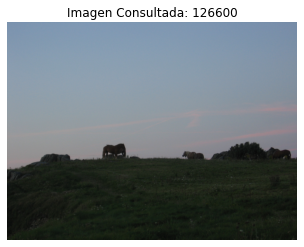

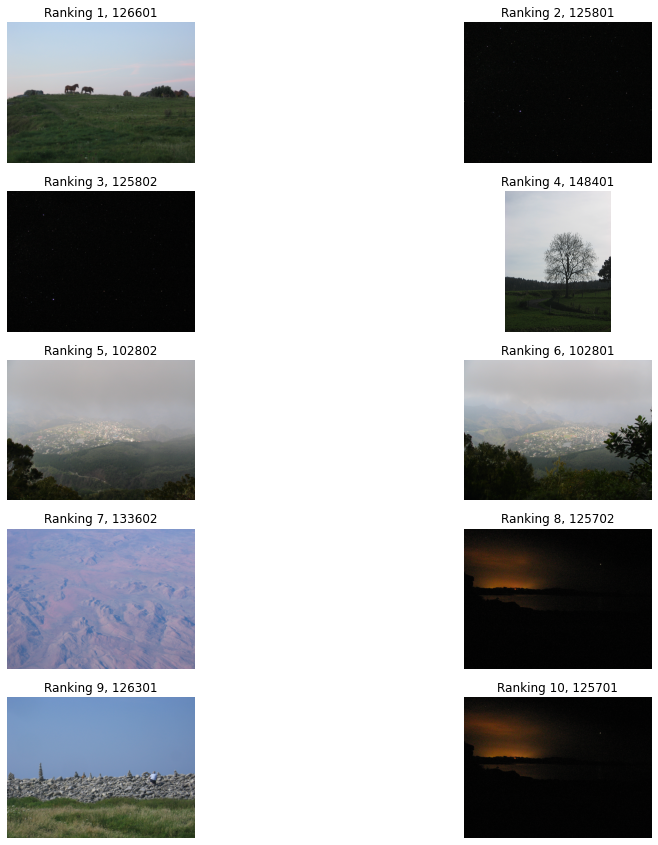

In [30]:
plot_rank('126600')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:32: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


Cantidad de Aciertos: 1 de 1


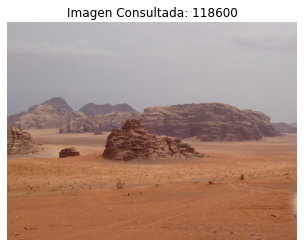

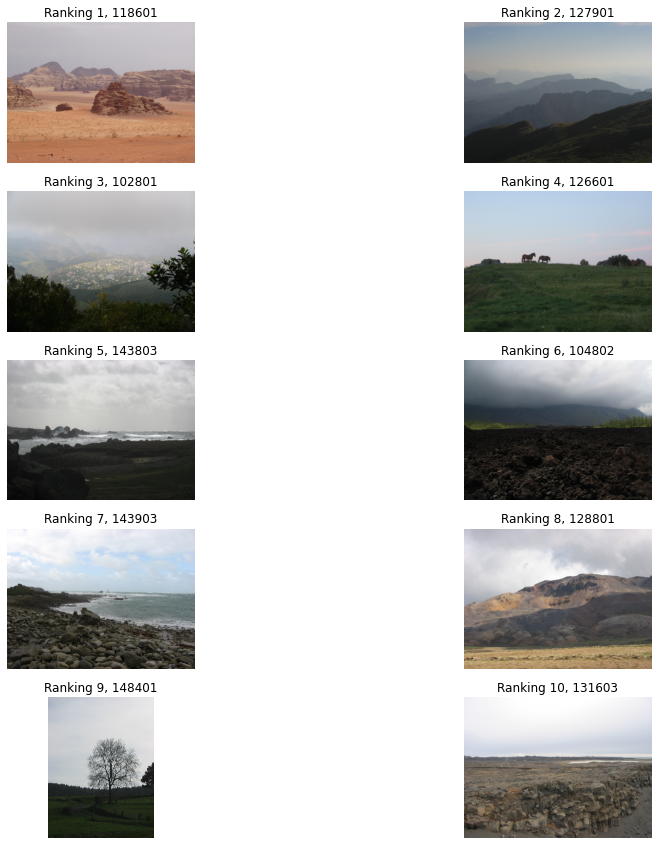

In [31]:
plot_rank('118600')